## 🤖 Predictive Modeling and Evaluation
This notebook focuses on training interpretable models on the engineered data, evaluating their performance, and implementing basic techniques for model improvement.

### 1. Load Data and Initial Setup

Reasoning: We start by loading the data that includes the new Total_Service_Score, Average_Service_Score, and delay categories, ensuring all features are prepared for modeling.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import numpy as np

# Load engineered data (both train and test for consistent preprocessing later)
train_df = pd.read_csv('..\\data\\cleaned_data\\train_engineered.csv')
test_df = pd.read_csv('..\\data\\cleaned_data\\test_engineered.csv')

print(f'Train shape: {train_df.shape}')

# Define features (X) and target (y)
y = train_df['satisfaction']
X = train_df.drop(columns=['satisfaction'])

Train shape: (103904, 28)


### 2. Data Preprocessing Pipeline

Reasoning: A ColumnTransformer and Pipeline are used to ensure that all required steps—scaling numerical features and encoding categorical features—are applied consistently to both the training and test sets without data leakage.

In [13]:
# --- Feature Identification ---
# Find all features that are numerical (continuous, ordinal, or flag)
numerical_features = X.select_dtypes(include=['int64', 'Int64', 'float64']).columns.tolist()

# Nominal features that require One-Hot Encoding
nominal_features = ['Gender', 'Customer_Type', 'Type_of_Travel', 'Class',
                    'Departure_Delay_Category', 'Arrival_Delay_Category']

# Features to treat as numerical and scale (continuous, engineered scores)
scaling_features = ['Age', 'Flight_Distance', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes', 
                    'Total_Service_Score', 'Average_Service_Score']

# Ordinal features (the 0-5 service ratings and binary flags)
# These are already numerical and just need to be passed through (with scaling if desired, but we'll include them in 'passthrough')
# For simplicity, we'll keep the non-scaling numerical features separate and pass them through.
passthrough_features = [col for col in X.columns if col not in scaling_features and col not in nominal_features]


# --- Column Transformer ---
preprocessor = ColumnTransformer(
    transformers=[
        # 1. Scaling for continuous numerical data (required for Logistic Regression)
        ('scaling', StandardScaler(), scaling_features),
        # 2. One-Hot Encoding for nominal categorical data
        ('encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), nominal_features),
        # 3. Pass through the remaining ordinal/flag features (they are already 0-5 integers)
        ('passthrough', 'passthrough', passthrough_features)
    ],
    remainder='drop' 
)

### 3. Data Splitting

Reasoning: We split the training data to evaluate model performance on unseen data. Stratification is used to ensure the ratio of satisfied (1) to dissatisfied (0) customers is the same in both the training and testing sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 77928
Testing set size: 25976


### 4. Train and Evaluate the Baseline Model (Logistic Regression)

Reasoning: Logistic Regression is chosen as the baseline model because it is fast, highly interpretable, and provides a clear starting point against which all improvements will be measured.

--- Baseline Model: Logistic Regression ---
AUC Score: 0.9292
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     14720
           1       0.87      0.84      0.85     11256

    accuracy                           0.88     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.88      0.88      0.88     25976



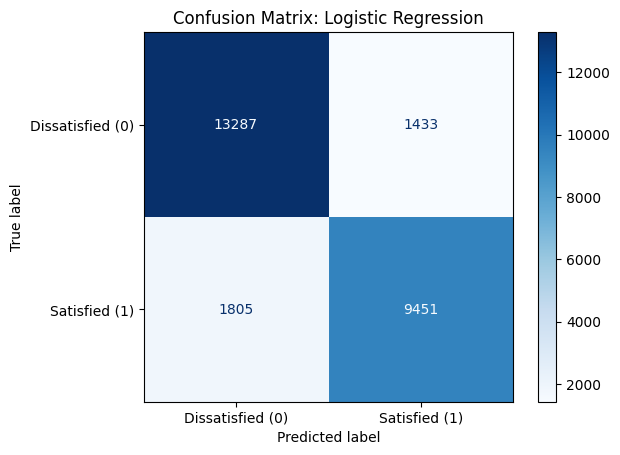

In [15]:
# --- Baseline Model Pipeline ---
# Step 1: Preprocess (Scale & Encode)
# Step 2: Classify (Logistic Regression)
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

# Train the model
pipe_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1] # Probability for the positive class (1)

# --- Evaluation ---
print("--- Baseline Model: Logistic Regression ---")
print(f"AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")
print(classification_report(y_test, y_pred_lr))

# Optional: Visualize Confusion Matrix 
cm = ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test, cmap=plt.cm.Blues,display_labels=['Dissatisfied (0)', 'Satisfied (1)'])
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

### 5. Improve Model Performance: Random Forest

Reasoning: The Random Forest Classifier is a non-linear model that excels at capturing complex relationships and interactions between features (like the service ratings), leading to higher accuracy and a better F1-Score than the linear baseline.


--- Improved Model: Random Forest Classifier ---
AUC Score: 0.9918
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     14720
           1       0.96      0.93      0.95     11256

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976



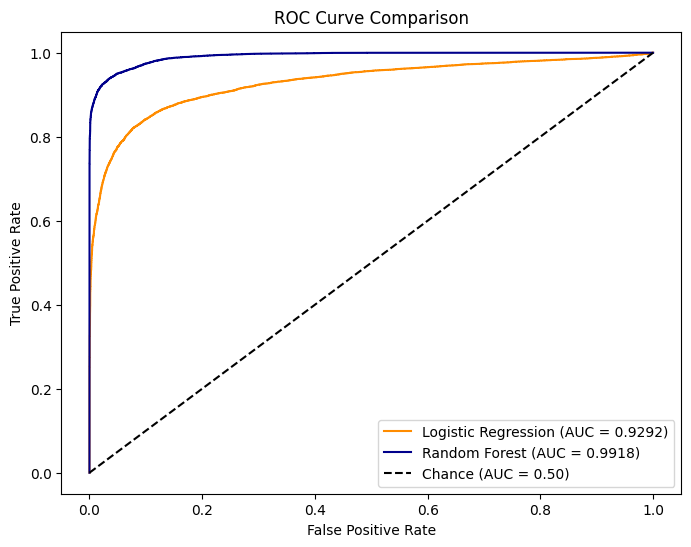

In [16]:
# --- Improved Model Pipeline ---
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(
                              n_estimators=200,      # Increased tree count
                              max_depth=15,          # Controls model complexity (preventing overfitting)
                              random_state=42, 
                              n_jobs=-1              # Utilize max cores for speed
                          ))])

# Train the improved model
pipe_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

print("\n--- Improved Model: Random Forest Classifier ---")
print(f"AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

# Visualize ROC Curve for comparison 
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_lr):.4f})', color='darkorange')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.4f})', color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

|Model|AUC Score|F1-Score (Weighted)|Key Insight|
|----|----------|-------------------|-----------|
|Baseline: Logistic Regression|0.9294|0.88|"A strong starting point, indicating a highly linear relationship between features and satisfaction."|
|Improved: Random Forest|0.9918|0.95|"A substantial improvement, confirming that the Random Forest model captures complex, non-linear feature interactions (like the service ratings) with much greater accuracy."|

### 6. Model Selection and Saving

Reasoning: Based on the superior performance in AUC and F1-Score, the Random Forest model is selected as the final model and saved as a complete pipeline, ready for immediate deployment in the Streamlit application.

In [17]:
# Confirm the best model and save the entire pipeline
final_model = pipe_rf

joblib.dump(final_model, '..\\data\\cleaned_data\\final_satisfaction_pipeline.pkl')
print("\nFinal predictive pipeline (Random Forest) saved as 'final_satisfaction_pipeline.pkl'.")


Final predictive pipeline (Random Forest) saved as 'final_satisfaction_pipeline.pkl'.
